<div style='padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Applied Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Lab: CAN Noise</div>
        </div>
    </div>
</div>

##### Authors:
* Carl Tape ([@carltape](https://github.com/carltape))
* Yongki Aiman
* Tomy Gunawan
* Angel Ling
---
based on *GEOS 626: Applied Seismology from Carl Tape*

---

### CAN noise

Analyzing the noise time series at CAN

In [1]:
# Preparation for programming
# Make sure to execute this cell first!
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import xcorr_pick_correction
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import wave
import struct
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['lines.linewidth'] = 1

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-17T00:58:53.019200Z - 2004-12-26T00:58:52.019200Z | 1.0 Hz, 777600 samples


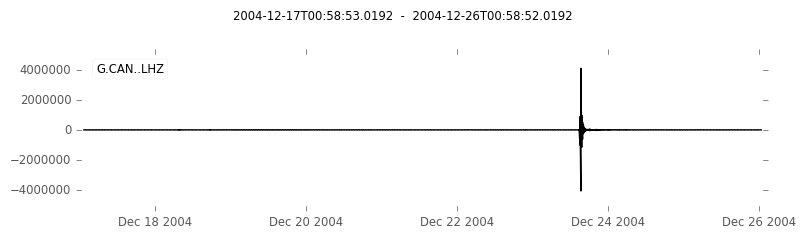

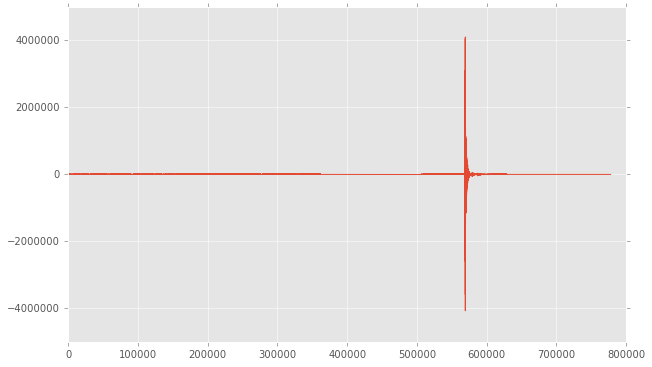

In [2]:
# Getting the waveforms

client = Client("IRIS")
t = UTCDateTime("2004-12-26T00:58:53.0")
starttime = t-(9*24*3600) # 10 days before the Sumatra earthquake
endtime = t # the original time of the Sumatra earthquake

st = client.get_waveforms("G", "CAN", "*", "LHZ", starttime, endtime, attach_response=True)
print(st)

st.plot()

# Plotting signals
tr = st[0]
trace_data = tr.data
plt.plot(tr.data)

1 Trace(s) in Stream:
G.CAN..LHZ | 2004-12-17T00:58:53.019200Z - 2004-12-26T00:58:52.019200Z | 1.0 Hz, 777600 samples


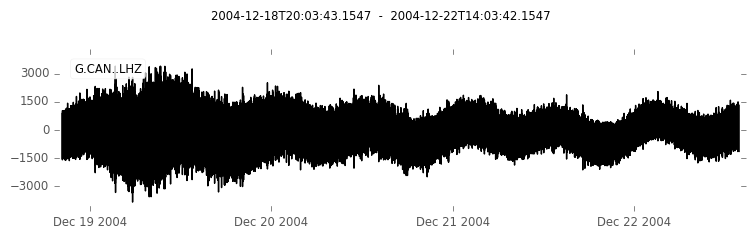

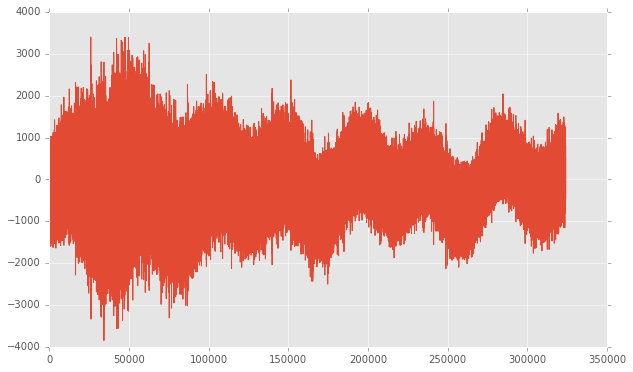

In [3]:
# Remove obvious earthquake 
t1 = UTCDateTime("2004-12-18T20:03:42.870")
starttime1 = t1 # 90 hours before the New Zealand earthquake
endtime1 = t1+(90*3600) # the original time of the New Zealand earthquake

st1 = client.get_waveforms("G", "CAN", "*", "LHZ", starttime1, endtime1, attach_response=True)
print(st)

st1.plot()

# Plotting signals
tr1 = st1[0]
trace_data = tr1.data
plt.plot(tr1.data)

Inventory created at 2017-12-20T10:30:57.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.32
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2004-12-17...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			G
		Stations (1):
			G.CAN (Canberra, Australia)
		Channels (1):
			G.CAN..LHZ


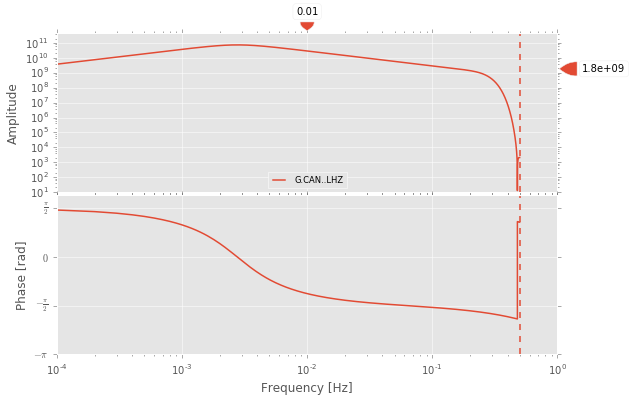

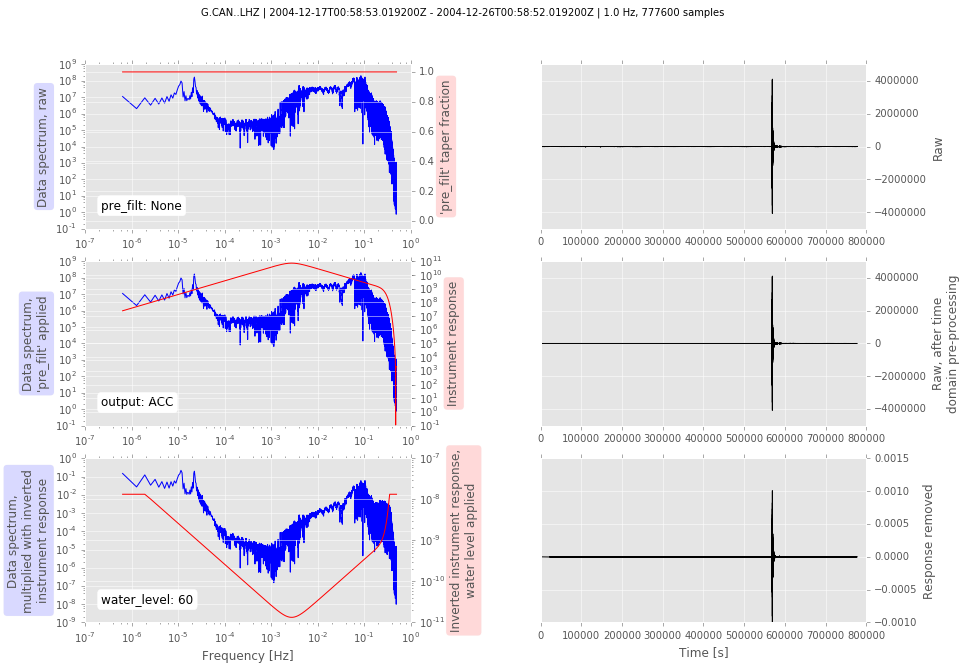

In [4]:
# Plot station response
inv = client.get_stations(network="G", station="CAN", channel="LHZ", level="response", 
                     starttime=starttime, endtime=endtime)
print(inv)

inv.plot_response(min_freq=1E-4, output='ACC')

tr_new = st.select(component="Z").copy().remove_response(
    inventory=inv, output="ACC", plot=True)[0]

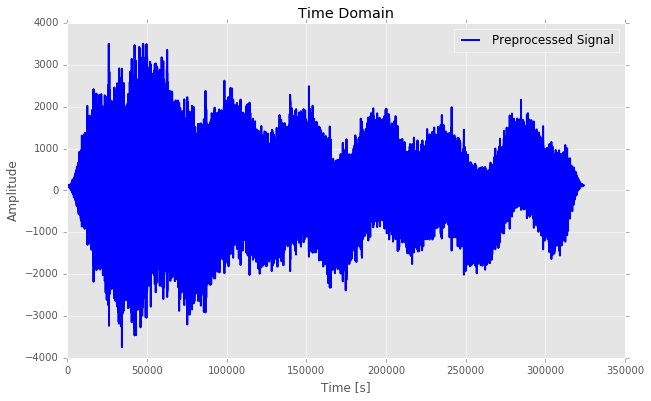

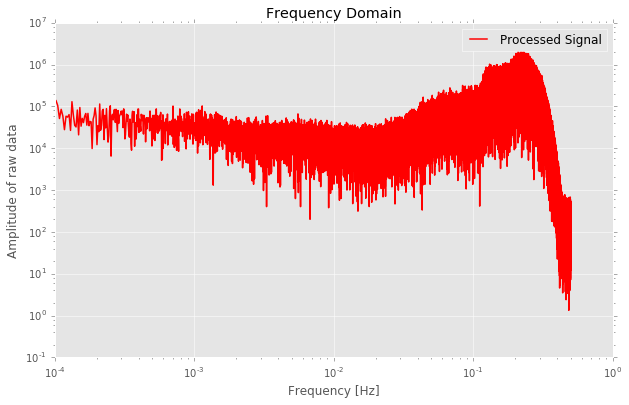

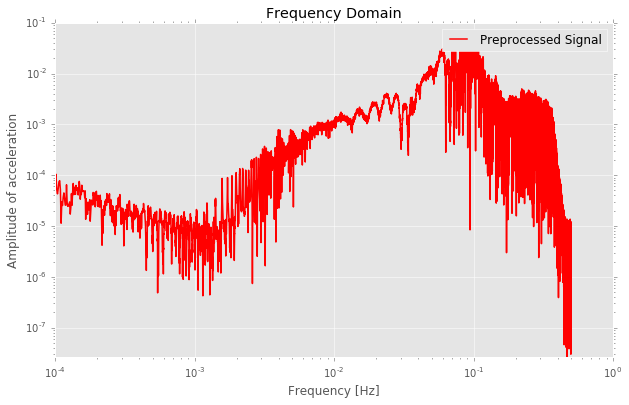

In [5]:
#Pre-Process Data 
from obspy.signal.filter import lowpass
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper 

# take a copy of the stream to avoid overwriting the original data
can = st1.copy()

# Choosing the 1st stream, Specify sampling parameters and Nyquist frequency
npts = can[0].stats.npts              # number of samples
df = can[0].stats.sampling_rate       # sampling rate
nsec = npts/df                        # sampling time
fNy = df / 2.0                        # Nyquist frequency
time = np.linspace(0,nsec,(nsec*df))  # time axis for plotting

y  = can[0].data                      # set up signal   

# Taper
taper_percentage = 0.1                          # Percentage of tapering applied to signal
taper = cosine_taper(npts,taper_percentage)    # Define cosine taper to be used
y_taper = y * taper                         # Taper signal

# Detrend Signal
y_detrend = detrend(y_taper, 'linear')

# Frequency Domain
y_fnew = np.fft.rfft(y_detrend) 

tr = st.select(component="Z").copy().remove_response(inventory=inv, output="ACC")[0].taper(0.05)
D = np.fft.rfft(tr.data)
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

# Plot the result
# Plot in Time Domain
freq = np.linspace(0, fNy, len(y_fnew))         # Frequency axis for plotting
plt.plot(time, y_detrend, 'b', label="Preprocessed Signal", lw=2) 
plt.legend()
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Plot in Frequency Domain (Frequency Spectrum)
plt.semilogx(freq, abs(y_fnew), 'r', label="Processed Signal", lw=1.5) 
plt.legend()
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude of raw data')
plt.yscale('log')
plt.xlim(1.0E-4, 1.0)
plt.ylim(1E-1, 1E7) # limited to lower frquencies
plt.show()

# Plot in Frequency Domain (Frequency Spectrum)
plt.semilogx(freqs, abs(D), 'r', label="Preprocessed Signal", lw=1.5) 
plt.legend()
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude of acceleration')
plt.yscale('log')
plt.xlim(1.0E-4, 1.0)
plt.ylim(0.0, 0.1)
plt.show()